In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mne

In [2]:
%matplotlib inline

In [3]:
# Loading data
raw =  mne.io.read_raw_fif("Subject-6_Non-VR.fif", preload=True)
nchan = raw.info['nchan']
raw.info['ch_names']

Opening raw data file C:\Users\sonal\EEG\Subject-6_Non-VR.fif...
Isotrak not found
    Range : 0 ... 23015 =      0.000 ...   179.805 secs
Ready.


<ipython-input-3-7ad6647088e5>:2: RuntimeWarning: This filename (C:\Users\sonal\EEG\Subject-6_Non-VR.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw =  mne.io.read_raw_fif("Subject-6_Non-VR.fif", preload=True)


Reading 0 ... 23015  =      0.000 ...   179.805 secs...


['CH 1', 'CH 3', 'CH 4', 'CH 6', 'CH 7', 'CH 8']

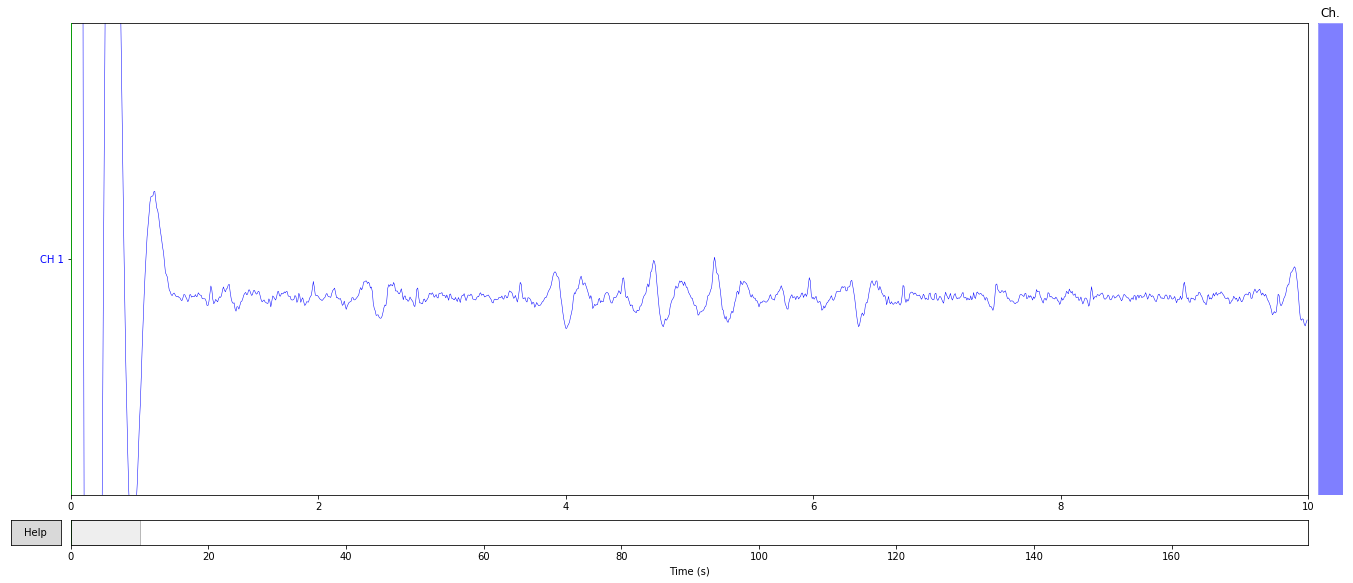

In [4]:
# ploting only one channel
scalings = {'eeg':400,'eeg':400,'eeg':400,'eeg':400,'eeg':400,'eeg':400,'eeg':400,'eeg':400}
color = {'eeg':'blue'}

ch_names = raw.info['ch_names']

raw_pick = raw.pick_channels(["CH 1"])  # getting one channel data | got from https://github.com/mne-tools/mne-python/issues/4699

raw_pick.plot(n_channels=1,scalings=scalings, color=color, title='Data from Channels', show=True, block=True);

In [5]:
# Getting one channel data as dataframe
raw_pick = raw.pick_channels(["CH 1"]) # get single channel
start, stop = raw_pick.time_as_index([10, 175]) # 10 s to 175 s data segment

picks = mne.pick_types(raw_pick.info, eeg=True, exclude=[])
data, times = raw_pick[picks[:], start:stop]

final_df = pd.DataFrame(data=data.T, columns=['Chan'])  # 1st row as the column names
final_df.head()

,Chan
0,-49.223904
1,-45.384220
2,-41.753246
3,-24.812943
4,-15.105989


In [26]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21120 entries, 0 to 21119
Data columns (total 1 columns):
Chan    21120 non-null float64
dtypes: float64(1)
memory usage: 165.1 KB


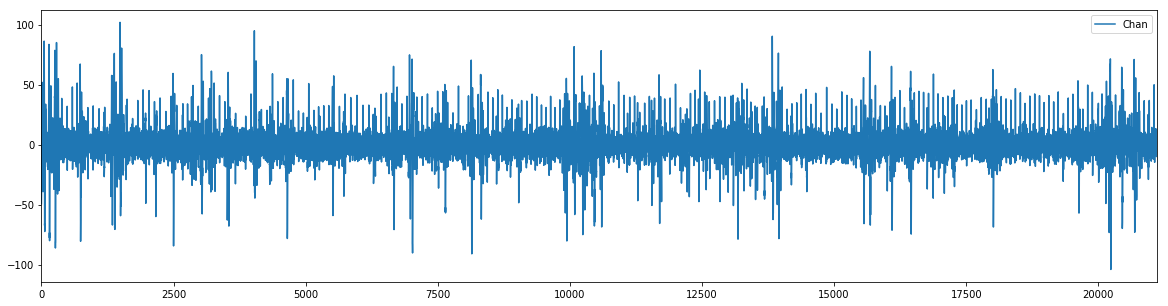

In [6]:
final_df.plot(figsize=(20,5))

#### Testing for Stationarity

In [7]:
from statsmodels.tsa.stattools import adfuller

In [8]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [9]:
#checking data is stationary or not
adf_check(final_df['Chan'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -50.35677251021685
p-value : 0.0
#Lags Used : 46
Number of Observations Used : 21073
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


#### AR model can be perfomr with stationary data only. If data is not stationary, then we'll take difference and make it stationary first.

##### Here, our data is stationary. However, Next I am taking 1 difference

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

### Auto correlation

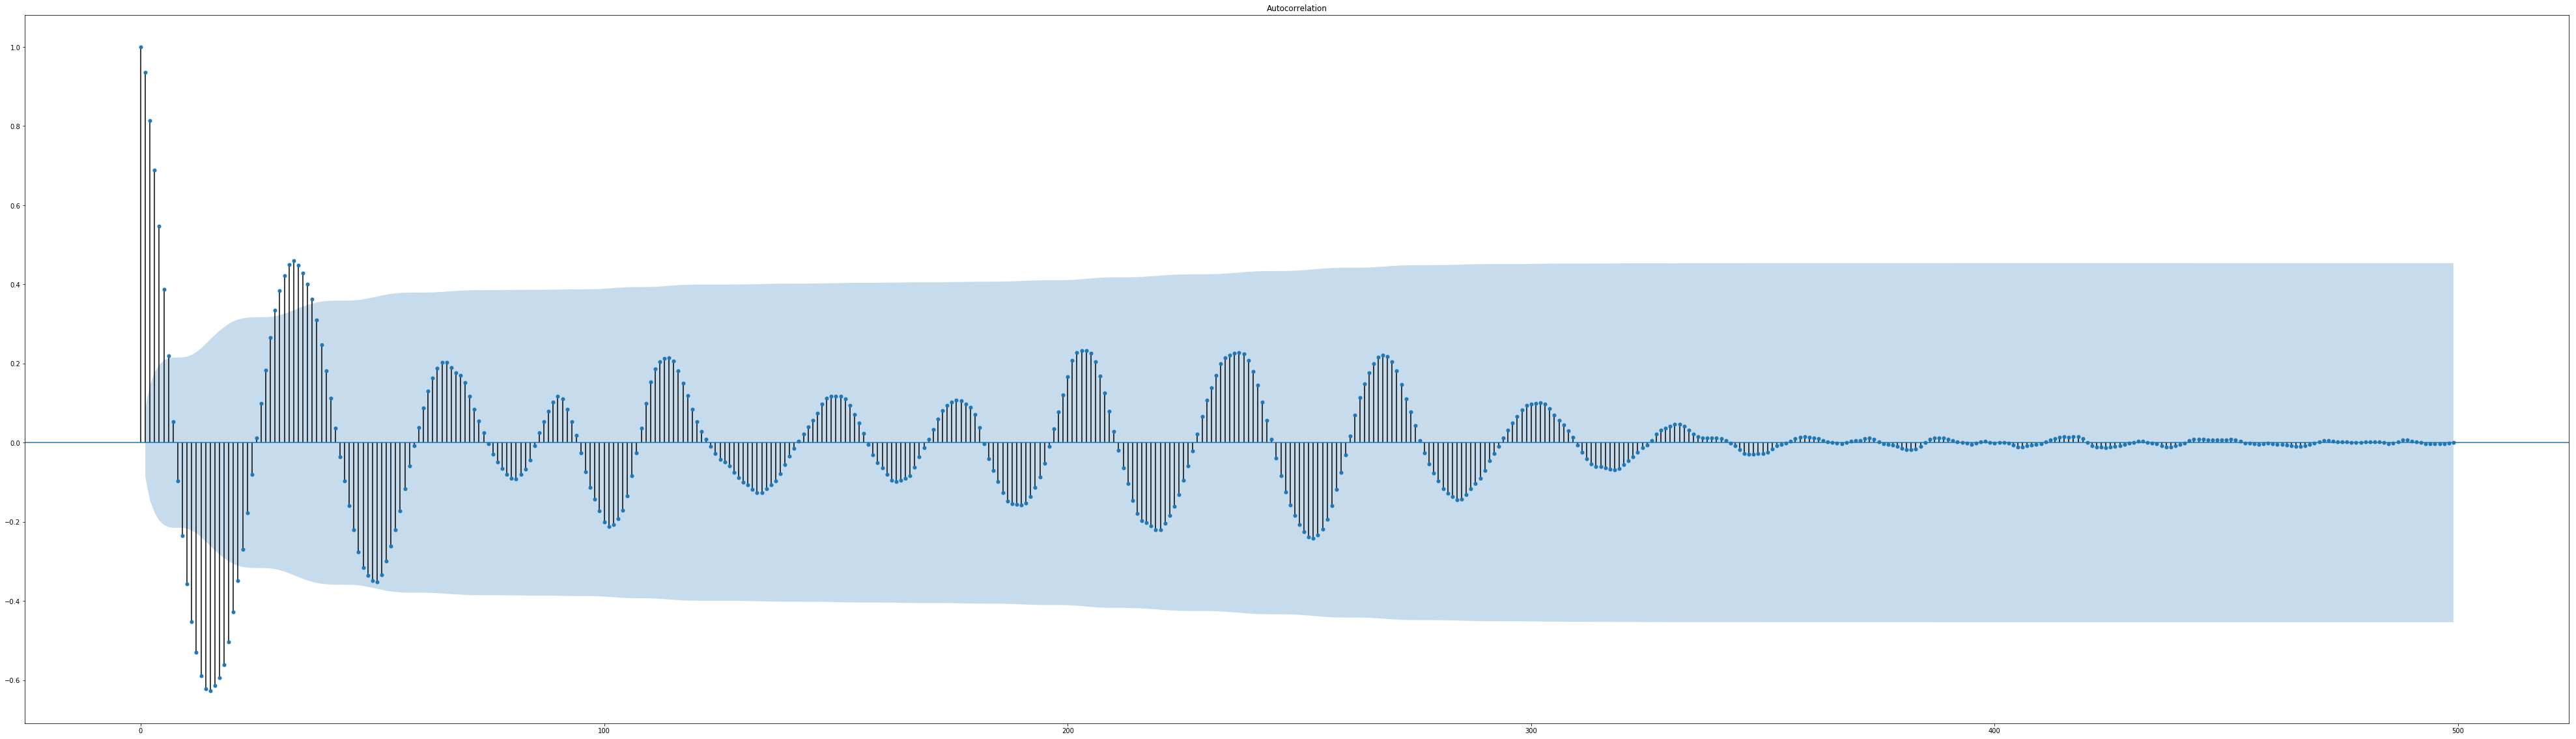

In [11]:
fig, ax = plt.subplots(figsize=(70, 20))
plot_acf(final_df[:500], ax=ax);

In [12]:
#take difference 1
diff = final_df.diff(periods=1)
# integrated of order 1 because here we are taking 1 lag/1 time difference
# it's denoted by d(diff), one of the parameter of ARIMA model

diff.dropna(inplace=True)
diff.head()

,Chan
1,3.839684
2,3.630974
3,16.940304
4,9.706953
5,5.552701


In [13]:
# checking data is stationary or not
adf_check(diff['Chan'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -53.3322643590111
p-value : 0.0
#Lags Used : 46
Number of Observations Used : 21072
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


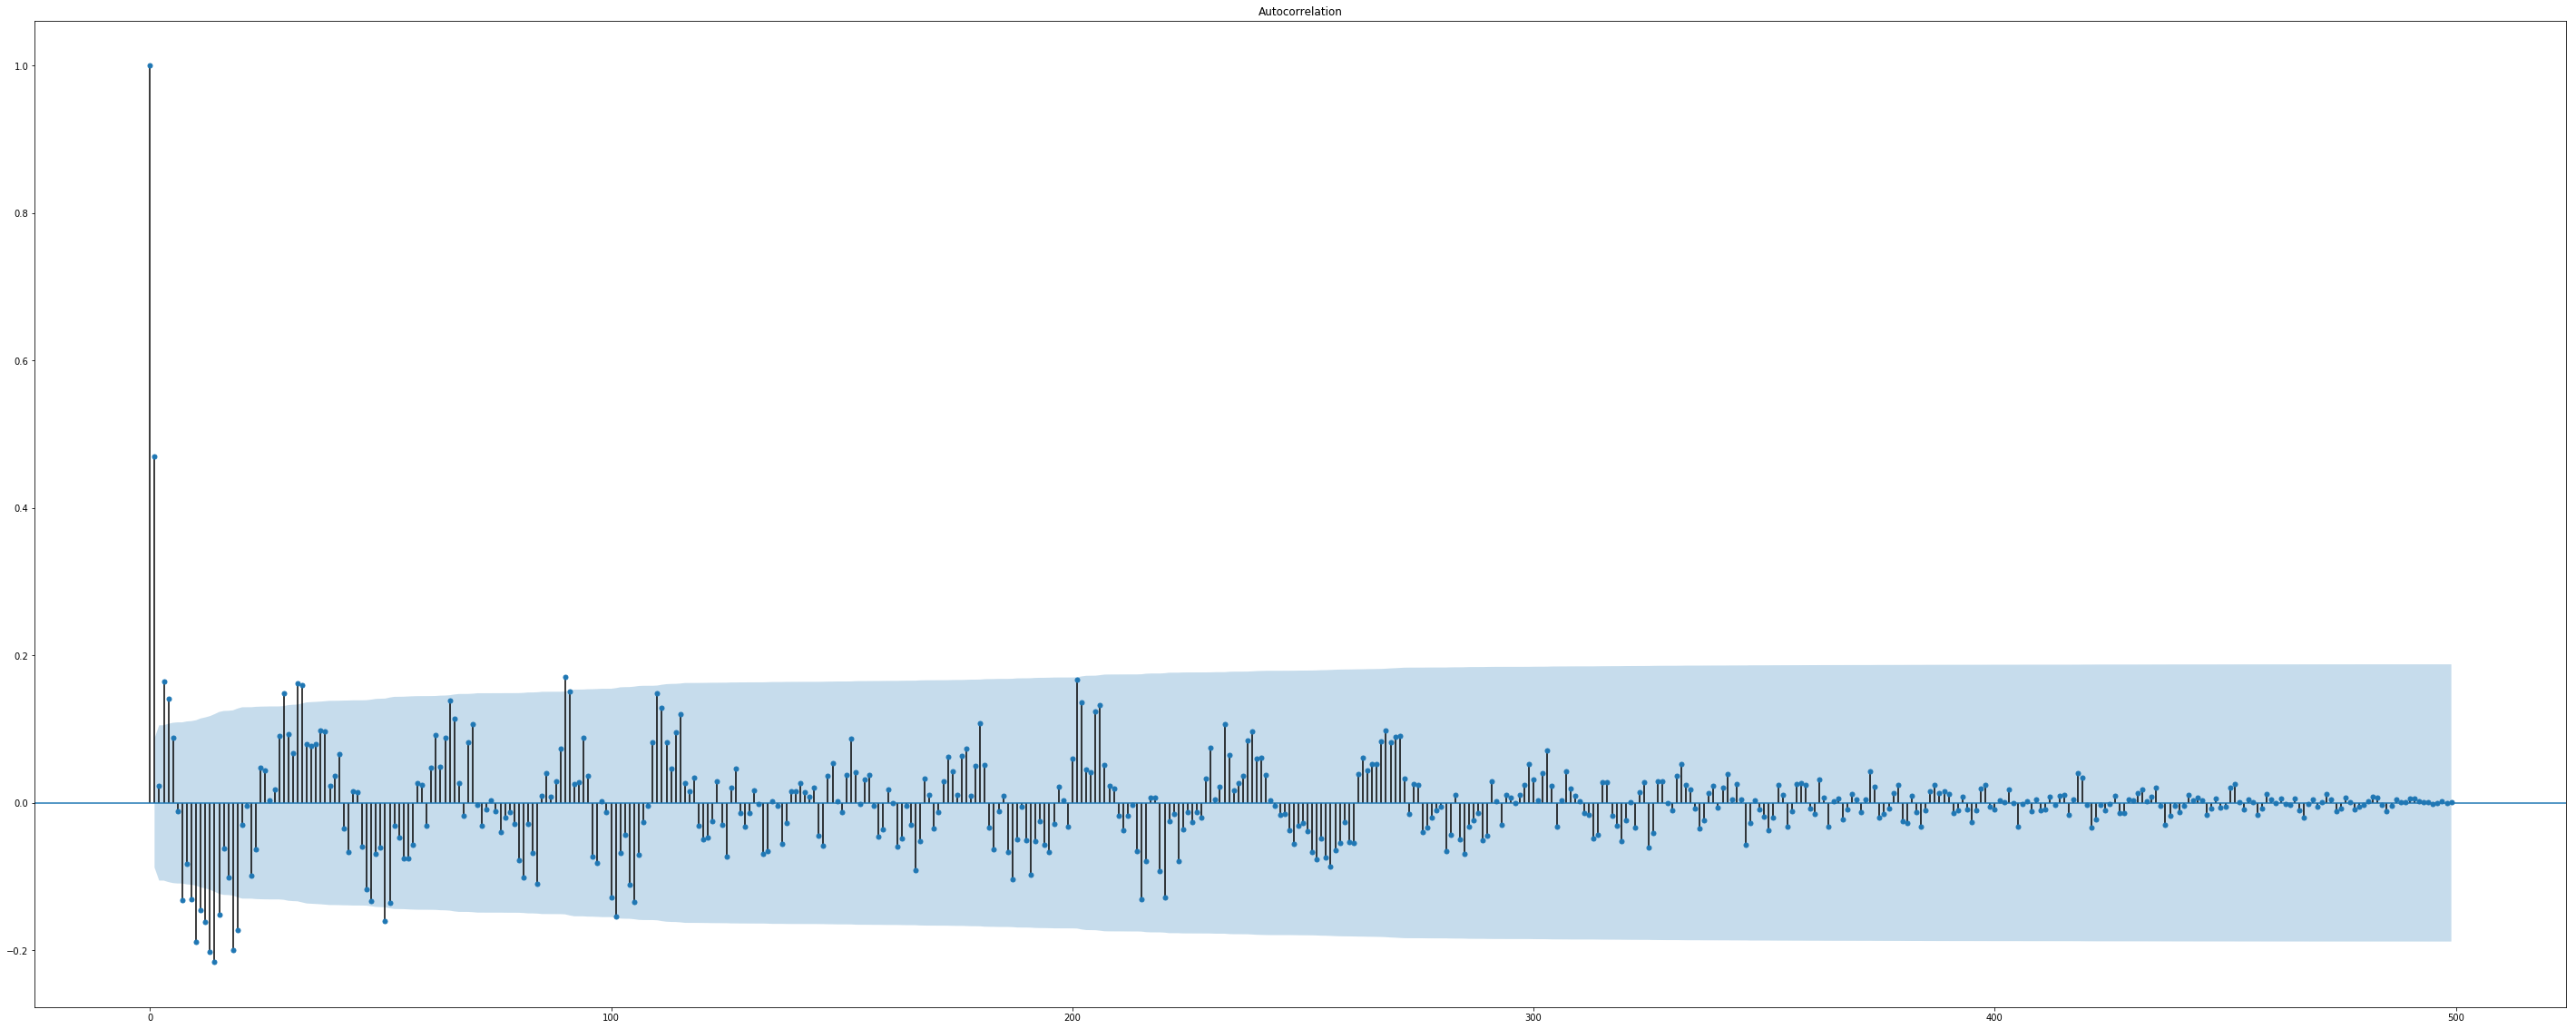

In [14]:
fig, ax = plt.subplots(figsize=(50, 20))
plot_acf(diff[:500], ax=ax);

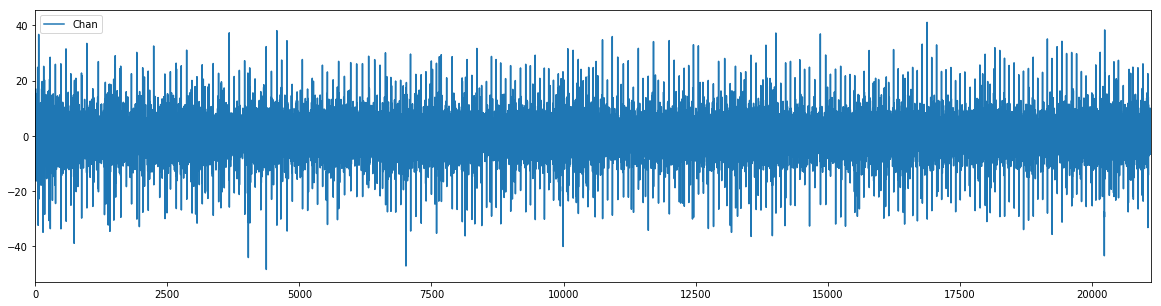

In [15]:
diff.plot(figsize=(20,5))

### Spliting Data

In [16]:
final_df.head()

,Chan
0,-49.223904
1,-45.384220
2,-41.753246
3,-24.812943
4,-15.105989


In [17]:
total_len = len(final_df)
train_len = round((total_len * 80)/100)
test_len = round((total_len * 40)/100)
print(train_len, test_len, total_len)

16896 8448 21120


In [18]:
X = final_df.Chan
train = X[1:train_len]
test = X[train_len:]
predictions = []
print("Train Size : " ,train.size,"and Test Size : ", test.size)

Train Size :  16895 and Test Size :  4224


### Auto regressive (AR)  model

In [19]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
model_ar = AR(train)
model_ar_fit = model_ar.fit(25)

In [20]:
print('The lag value chose is: %s' % model_ar_fit.k_ar)

The lag value chose is: 25


In [21]:
start=len(train)
end=len(train) + len(test)-1

predictions = model_ar_fit.predict(start=test_len,end=end)
predictions

8449     20.216615
8450     37.772277
8451     47.141416
8452      8.694574
8453     -4.126604
8454      2.520968
8455     -3.489752
8456     -6.526872
8457     -4.360354
8458     -8.839487
8459     -9.979340
8460    -10.918759
8461     -5.743841
8462      2.435257
8463     -2.079853
8464     -9.889833
8465     -9.275769
8466    -11.516947
8467     -5.474651
8468     -7.090619
8469     -6.330145
8470      2.958858
8471     -4.473067
8472     -1.327072
8473      2.379256
8474     -7.127672
8475     -3.268659
8476      7.661170
8477      5.964731
8478      3.796868
           ...    
21090    -0.000856
21091    -0.000856
21092    -0.000856
21093    -0.000856
21094    -0.000856
21095    -0.000856
21096    -0.000856
21097    -0.000856
21098    -0.000856
21099    -0.000856
21100    -0.000856
21101    -0.000856
21102    -0.000856
21103    -0.000856
21104    -0.000856
21105    -0.000856
21106    -0.000856
21107    -0.000856
21108    -0.000856
21109    -0.000856
21110    -0.000856
21111    -0.

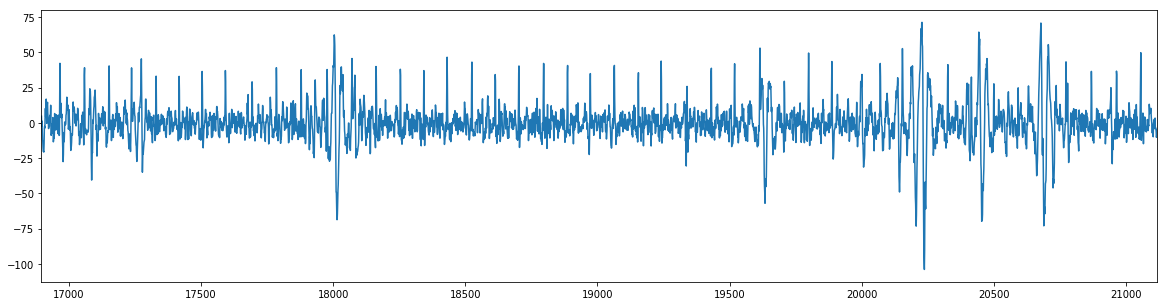

In [22]:
test.plot(figsize=(20,5))  # 80 % train data

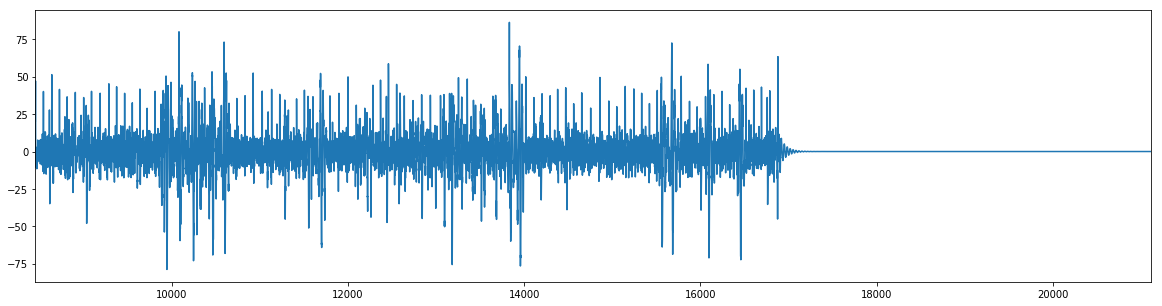

In [23]:
predictions.plot(figsize=(20,5)) # from 40% to all at the end, testing data

### Both Above graphs togather

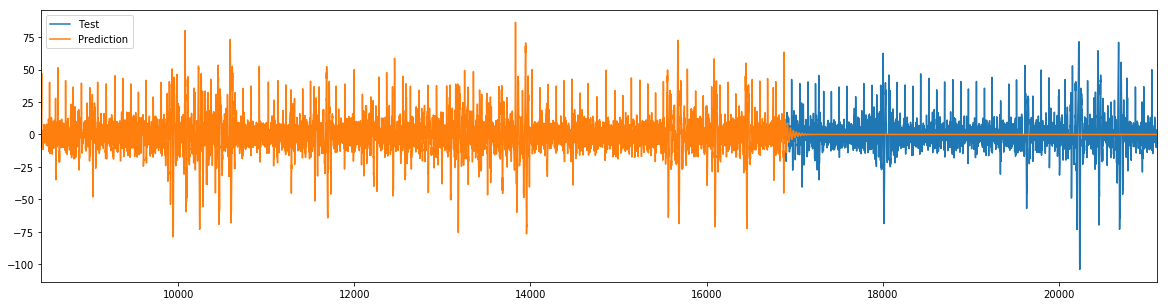

In [25]:
test.plot(figsize=(20,5),label='Test')  # 80 % train data
predictions.plot(figsize=(20,5),label='Prediction') # from 40% to all at the end, testing data
plt.legend()